In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model

In [2]:
# Data Load
df = pd.read_csv('D:/Denoising/Autoencoder/LSTM_SAE/RawData/Samsung.txt', sep = ',')

In [3]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['CLOSE']])
df["Close"] = scaled

In [4]:
# Make Time Series Data Set
size = 20
total_stock_list2 = np.zeros((len(df)-size+1,size,1))
count = 0
for i in range(len(df)-size+1):
    end_idx = i+size
    dff = df[i:end_idx]
    dff.reset_index(inplace = True)
    if len(dff)>=size:
        for j in range(size):
            total_stock_list2[count][j][0] = dff["Close"][j]            
        count += 1
    #print("{} / {}".format(i+1, len(total_stock_list2)))
    
# Split Train and Test Set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(total_stock_list2, total_stock_list2, test_size=0.2, random_state=42)

In [5]:
# Build Model
model = keras.Sequential()

timestamp = total_stock_list2.shape[1]
features = total_stock_list2.shape[2]

# Encoder LSTM cell1
model.add(keras.layers.LSTM(units=20, input_shape=(timestamp, features), return_sequences = True))
model.add(keras.layers.Dropout(rate=0.2))

# Encoder LSTM cell2
model.add(keras.layers.LSTM(units=15, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# Encoder LSTM cell3
model.add(keras.layers.LSTM(units=10, return_sequences=False))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.RepeatVector(timestamp))

# Decoder LSTM cell1
model.add(keras.layers.LSTM(units=10, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# Decoder LSTM cell2
model.add(keras.layers.LSTM(units=15, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# Decoder LSTM cell3
model.add(keras.layers.LSTM(units=20, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(features)))
model.compile(loss='mse', optimizer = Adam(learning_rate = 0.0001))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 20)            1760      
                                                                 
 dropout (Dropout)           (None, 20, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 15)            2160      
                                                                 
 dropout_1 (Dropout)         (None, 20, 15)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 20, 10)           0

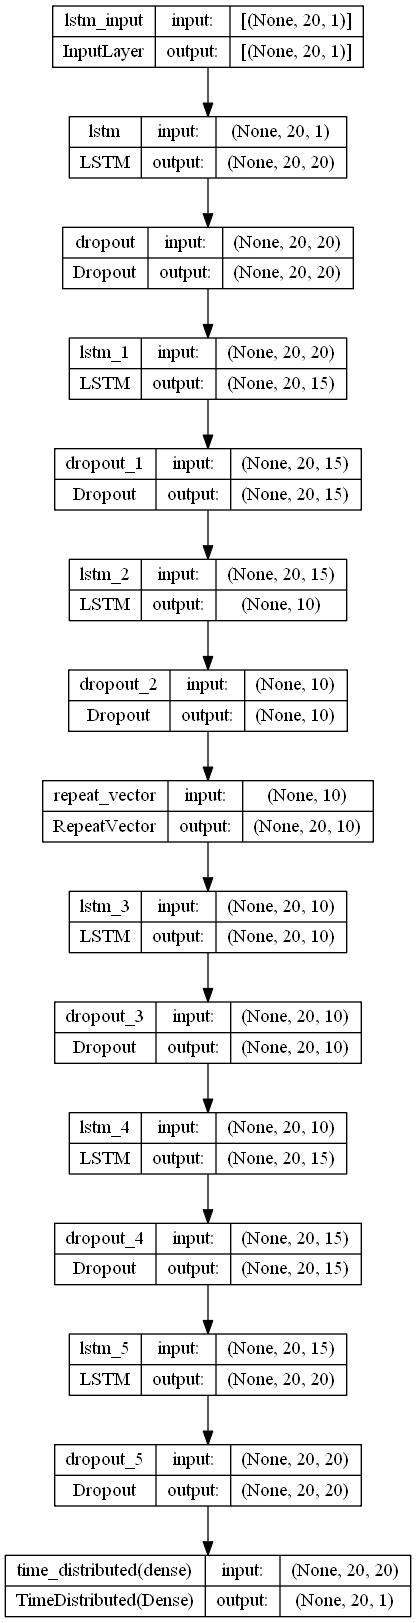

In [6]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [7]:
# Train Model
history = model.fit(x_train, y_train, epochs=500, batch_size=10,validation_split=0.1,shuffle=True, verbose=0)

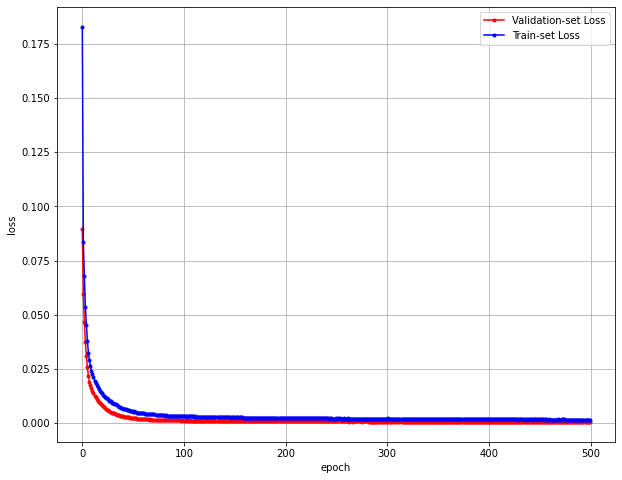

In [8]:
# Check Loss
plt.figure(figsize = (10,8))
y_vloss = history.history["val_loss"]
y_loss = history.history["loss"]

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c ='red', label = 'Validation-set Loss')
plt.plot(x_len, y_loss, marker='.', c ='blue', label = 'Train-set Loss')


plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [9]:
# Predict
pred = model.predict(total_stock_list2)

# Sum all window size units
mean_list = [0 for i in range(len(df))]
for i in range(len(total_stock_list2)):
    for j in range(20):
        mean_list[i+j] += pred[i][j]

# Calculate average
mean_list2= []
count = 19
for i in range(len(mean_list)):
    if i < 20:
        mean_list2.append(mean_list[i] / (i+1))
    elif i >=20 and (i <= len(mean_list)-20):
        mean_list2.append(mean_list[i] / 20)
    else:
        mean_list2.append(mean_list[i] / count)
        count -= 1


46/46 [==============================] - 6s 9ms/step


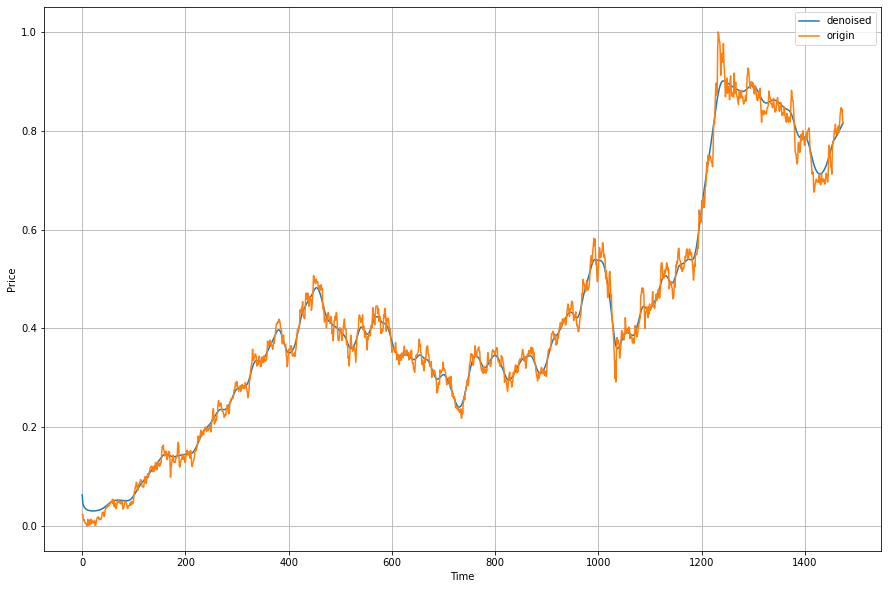

In [10]:
# Compare origin and denoised
st_price = []
for i in range(len(df["Close"])):
    st_price.append(df["Close"][i])

plt.figure(figsize = (15,10))
plt.plot(mean_list2, label = 'denoised')
plt.plot(st_price, label = 'origin')
plt.grid()
plt.legend(loc ='upper right')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()